In [1]:
import math
import numpy as np
import random

import pandas as pd
from downcast import reduce

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb

# IMPORT DATA

In [2]:
IS_IOWA_DATASET = True  # iowa dataset : true, simulation : false
IOWA_PATH = '../../datasets/train_data_iowa.csv'
SIMULATION_PATH = '../../datasets/datensatz_emre.csv'
CSV_PATH = IOWA_PATH if IS_IOWA_DATASET else SIMULATION_PATH

In [3]:
features = [
    "location_x", "location_y",
    "restaurant_location_x", "restaurant_location_y", 
    "order_time",
    "atd",
    "etd",
    "restaurant_queue",
    "max_pre_shift",
    "max_post_shift",
    "restaurants_before_customer",
    "customers_before_customer",
    "len_vehicle_route_to_customer",
]

for i in range(23):
    features.append(f"vehicle_route_to_customer_pos_x_{i}")
    features.append(f"vehicle_route_to_customer_pos_y_{i}")
    features.append(f"vehicle_route_to_customer_action_{i}")
    features.append(f"vehicle_route_to_customer_time_action_{i}") 

In [4]:
# Import data
meta = pd.read_csv(CSV_PATH, header=0, sep=";", usecols=features, nrows=1)
meta = reduce(meta)

data = pd.read_csv(CSV_PATH, header=0, sep=";", usecols=features, dtype=meta.dtypes.to_dict())
pd.set_option("display.max_columns", len(data.columns))
data

,order_time,atd,etd,restaurant_queue,max_pre_shift,max_post_shift,location_x,location_y,restaurant_location_x,restaurant_location_y,restaurants_before_customer,customers_before_customer,len_vehicle_route_to_customer,vehicle_route_to_customer_pos_x_0,vehicle_route_to_customer_pos_y_0,vehicle_route_to_customer_action_0,vehicle_route_to_customer_time_action_0,vehicle_route_to_customer_pos_x_1,vehicle_route_to_customer_pos_y_1,vehicle_route_to_customer_action_1,vehicle_route_to_customer_time_action_1,vehicle_route_to_customer_pos_x_2,vehicle_route_to_customer_pos_y_2,vehicle_route_to_customer_action_2,vehicle_route_to_customer_time_action_2,vehicle_route_to_customer_pos_x_3,vehicle_route_to_customer_pos_y_3,vehicle_route_to_customer_action_3,vehicle_route_to_customer_time_action_3,vehicle_route_to_customer_pos_x_4,vehicle_route_to_customer_pos_y_4,vehicle_route_to_customer_action_4,vehicle_route_to_customer_time_action_4,vehicle_route_to_customer_pos_x_5,vehicle_route_to_customer_pos_y_5,vehicle_route_to_customer_action_5,vehicle_route_to_customer_time_action_5,vehicle_route_to_customer_pos_x_6,vehicle_route_to_customer_pos_y_6,vehicle_route_to_customer_action_6,vehicle_route_to_customer_time_action_6,vehicle_route_to_customer_pos_x_7,vehicle_route_to_customer_pos_y_7,vehicle_route_to_customer_action_7,vehicle_route_to_customer_time_action_7,vehicle_route_to_customer_pos_x_8,vehicle_route_to_customer_pos_y_8,vehicle_route_to_customer_action_8,vehicle_route_to_customer_time_action_8,vehicle_route_to_customer_pos_x_9,vehicle_route_to_customer_pos_y_9,vehicle_route_to_customer_action_9,vehicle_route_to_customer_time_action_9,vehicle_route_to_customer_pos_x_10,vehicle_route_to_customer_pos_y_10,vehicle_route_to_customer_action_10,vehicle_route_to_customer_time_action_10,vehicle_route_to_customer_pos_x_11,vehicle_route_to_customer_pos_y_11,vehicle_route_to_customer_action_11,vehicle_route_to_customer_time_action_11,vehicle_route_to_customer_pos_x_12,vehicle_route_to_customer_pos_y_12,vehicle_route_to_customer_action_12,vehicle_route_to_customer_time_action_12,vehicle_route_to_customer_pos_x_13,vehicle_route_to_customer_pos_y_13,vehicle_route_to_customer_action_13,vehicle_route_to_customer_time_action_13,vehicle_route_to_customer_pos_x_14,vehicle_route_to_customer_pos_y_14,vehicle_route_to_customer_action_14,vehicle_route_to_customer_time_action_14,vehicle_route_to_customer_pos_x_15,vehicle_route_to_customer_pos_y_15,vehicle_route_to_customer_action_15,vehicle_route_to_customer_time_action_15,vehicle_route_to_customer_pos_x_16,vehicle_route_to_customer_pos_y_16,vehicle_route_to_customer_action_16,vehicle_route_to_customer_time_action_16,vehicle_route_to_customer_pos_x_17,vehicle_route_to_customer_pos_y_17,vehicle_route_to_customer_action_17,vehicle_route_to_customer_time_action_17,vehicle_route_to_customer_pos_x_18,vehicle_route_to_customer_pos_y_18,vehicle_route_to_customer_action_18,vehicle_route_to_customer_time_action_18,vehicle_route_to_customer_pos_x_19,vehicle_route_to_customer_pos_y_19,vehicle_route_to_customer_action_19,vehicle_route_to_customer_time_action_19,vehicle_route_to_customer_pos_x_20,vehicle_route_to_customer_pos_y_20,vehicle_route_to_customer_action_20,vehicle_route_to_customer_time_action_20,vehicle_route_to_customer_pos_x_21,vehicle_route_to_customer_pos_y_21,vehicle_route_to_customer_action_21,vehicle_route_to_customer_time_action_21,vehicle_route_to_customer_pos_x_22,vehicle_route_to_customer_pos_y_22,vehicle_route_to_customer_action_22,vehicle_route_to_customer_time_action_22
0,567,583,584,8,0,0,4.562500,8.312500,4.996094,10.343750,1,1,4,4.996094,10.343750,1,4,4.996094,10.343750,3,5,4.562500,8.312500,2,5,4.562500,8.312500,4,3,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0
1,587,613,610,8,0,0,13

# FEATURE ENGINEERING

Features used in Hildebrandt et al. (2020):
<ul>
    <li>n_stops: sum(vehicle_route_to_customer_action_i = 1 or 2)</li>
    <li>n_pickup_stops: sum(vehicle_route_to_customer_action_i = 1)</li>
    <li>n_delivery_stops: sum(vehicle_route_to_customer_action_i = 2)</li>
    <li>max_pre_shift: already given</li>    
    <li>max_post_shift: already given</li>
    <li>prep_time: sum(v_r_t_c_time_action_*) where v_r_t_c_action_i = 3 and v_r_t_c_pos_j == restaurant_location</li>
    <li>order_time: already given</li>
    <li>eta_pom: already given</li>
    <li>customer_location: already given</li>
    <li>restaurant_location: already given</li>
</ul>
Couple more? Brainstorming
<ul>
    <li>Split up eta_pom (i.e sum of estimated waiting times, delivery times (not anticipative)</li>
    <li>

In [5]:
#Define strings to identify needed columns for each feature we want to craft
query_strings = {
    "n_stops" : ["vehicle_route_to_customer_action"],
        
    "n_pickup_stops" : ["vehicle_route_to_customer_action"],
    
    "n_delivery_stops" : ["vehicle_route_to_customer_action"],
    
    "prep_time" : ["vehicle_route_to_customer_time_action", 
                   "vehicle_route_to_customer_action",
                   "order_time", "restaurant_location", "vehicle_route_to_customer_pos"]
}

raw_feats = [
    "location_x", "location_y",
    "restaurant_location_x", "restaurant_location_y",
    "etd", 
    "atd", 
    "order_time", 
    "max_pre_shift", 
    "max_post_shift", 
    "restaurant_queue"]

mask = pd.DataFrame()
feats = pd.DataFrame()

# First, add used raw features to feats
for feat in raw_feats:
    feats[feat] = data[feat]

# Craft features and add to feats
for key,value in query_strings.items():
    
    needed_columns = [col for col in data.columns if any(x in col for x in value)]
    inp = data[needed_columns]
    
    if key == "n_stops":
        for col in inp:
            mask[col] = (inp[col] > 0) & (inp[col] < 3)
            feats[key] = mask.sum(axis=1)
    
    if key == "n_pickup_stops": 
        for col in inp:
            mask[col] = inp[col] == 1
            feats[key] = mask.sum(axis=1)
    
    if key == "n_delivery_stops": 
        for col in inp:
            mask[col] = inp[col] == 2
            feats[key] = mask.sum(axis=1)

In [8]:
CF_PATH = "../../datasets/crafted_features.csv"
feats.to_csv(CF_PATH, sep=";")

In [9]:
crafted_features = pd.read_csv(CF_PATH, sep=";", index_col=[0])
crafted_features

,location_x,location_y,restaurant_location_x,restaurant_location_y,etd,atd,order_time,max_pre_shift,max_post_shift,restaurant_queue,n_stops,n_pickup_stops,n_delivery_stops
0,4.562,8.310,4.996,10.340,584,583,567,0,0,8,2,1,1
1,13.234,3.943,7.906,3.838,610,613,587,0,0,8,2,1,1
2,7.633,7.270,4.996,10.340,623,623,602,0,0,8,2,1,1
3,7.664,7.434,3.521,9.430,639,641,617,0,0,8,2,1,1
4,12.930,6.020,6.766,6.617,645,646,618,0,0,8,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
850464,4.098,11.200,3.521,9.430,1225,1224,1191,11,0,8,4,1,3
850465,13.110,4.996,7.050,10.210,1246,1246,1200,9,0,8,4,1,3
850466,12.510,2.494,9.734,5.387,1242,1244,1202,12,0,8,4,1,3
850467,0.903,10.480,9.734,5.387,1247,1246,1207,14,0,11,2,1,1


In [11]:
X = data.loc[:, data.columns != 'atd']
y = data['atd'] - data['etd']

X_train, X_test, y_train , y_test = train_test_split(X,y, train_size=0.8)

X_crafted = crafted_features.loc[:, crafted_features.columns != 'atd']
y_crafted = crafted_features['atd'] - crafted_features['etd']

X_train_c, X_test_c, y_train_c , y_test_c = train_test_split(X_crafted,y_crafted, train_size=0.8)

In [ ]:
# Encoding categorical variables ("insertion index")
#--> Later, when Florentins features are crafted

<AxesSubplot:>

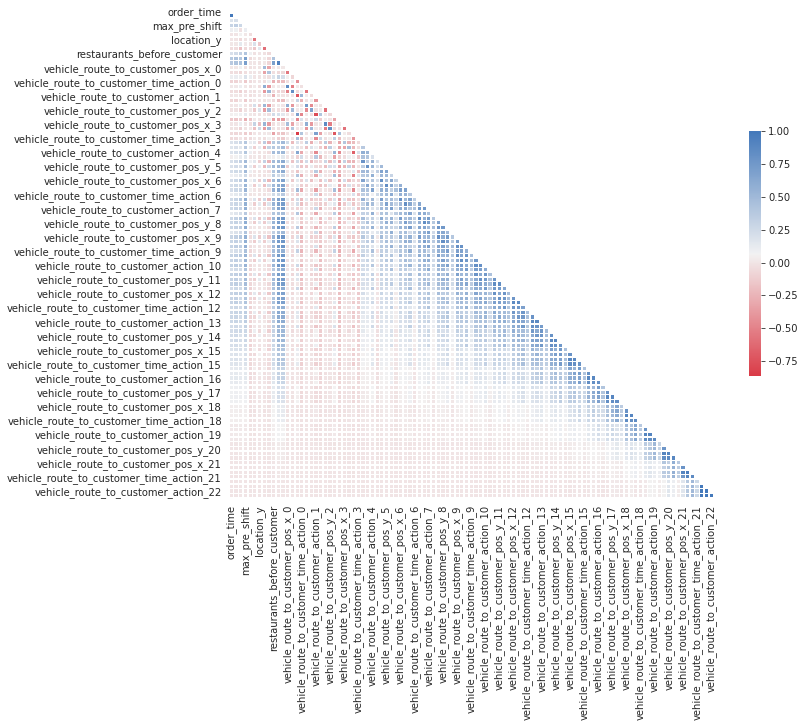

In [13]:
%matplotlib inline
import seaborn as sns

# use the pands .corr() function to compute pairwise correlations for the dataframe
corr = X.corr()
# visualise the data with seaborn
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [ ]:
# Data description
def plot_histogram(x):
    plt.hist(x, color='gray', alpha=0.5)
    plt.title(f"Histogram of {x.name}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

# ENSEMBLE LEARNING

### Set parameters for each model (HyperOpt)

In [ ]:
params = {
    "lgbm_rf" : {
        "boosting_type" : "rf",
        "objective" : "regression",
        "learning_rate" : 0.0005,
        "random_state" : 42,
        "metrics" : "l2",
        "bagging_freq" : 10,
        "bagging_fraction" : 0.8,
    },
    
    "lgbm_gbdt" : {
        "boosting_type" : "gbdt",
        "objective" : "regression",
        "learning_rate" : 0.05,
        "num_leaves" : 20,
        "random_state" : 42,
        'metrics' : 'l2',    
    },
    
    #"lgbm_goss" : {
    #    "boosting_type" : "goss",
    #    "objective" : "regression",
    #     "n_estimators" : 500,
    #    "learning_rate" : 0.05,
    #    "random_state" : 42,
    #    'metric' : 'l2'
    #},
    #"lgbm_dart" : {
    #    "boosting_type" : "dart",
    #    "objective" : "regression",
    #     "n_estimators" : 500,
    #    "learning_rate" : 0.05,
    #    "random_state" : 42,
    #    'metric' : 'l2'
    #}
}

## Train models on raw set

In [ ]:
raw_set = lgb.Dataset(X,y)

trained_models = []
for model in params:
    bst = lgb.cv(
        params[model],
        raw_set,
        num_boost_round = 500,
        early_stopping_rounds = 10,
        verbose_eval = 5,
        seed = 42,
        return_cvbooster = True,
        stratified=False
    )
    trained_models.append(bst)

In [ ]:
# Always scale the input. The most convenient way is to use a pipeline.
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(
                        max_iter=1000,
                        validation_fraction=0.2,
                        learning_rate="adaptive",
                        verbose = 1)
                   )
reg.fit(X_crafted, y_crafted)
mean_squared_error(y_test_c, reg.predict(X_test_c))

In [ ]:
crafted_set = lgb.Dataset(X_crafted,y_crafted)

trained_models = []
for model in params:
    bst = lgb.cv(
        params[model],
        train_set,
        num_boost_round = 500,
        early_stopping_rounds = 10,
        verbose_eval = 5,
        seed = 42,
        return_cvbooster = True,
    )
    trained_models.append(bst)

# NEURAL NETWORK (Pytorch or Tensorflow)

### TODO:
- Experiment with different architectures and techniques (i.e. MLP, Convolutional NNs (?) , ...) 

# 1. Model definition

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CancelOut(nn.Module):
    '''
    CancelOut Layer
    
    x - an input data (vector, matrix, tensor)
    '''

    def __init__(self, inp, *kargs, **kwargs):
        super(CancelOut, self).__init__()
        self.weights = nn.Parameter(torch.zeros(inp, requires_grad=True) + 4)

    def forward(self, x):
        return x * torch.sigmoid(self.weights.float())

class Autoencoder(torch.nn.Module):
    def __init__(self, n_features, n_hidden, n_encode):
        super(Autoencoder, self).__init__()
        self.hidden_enc = nn.Linear(n_features, n_hidden)
        self.encode = nn.Linear(n_hidden, n_encode)
        self.hidden_dec = nn.Linear(n_encode, n_hidden)
        self.decode = nn.Linear(n_hidden, n_features)

    def forward(self, x):
        x = F.leaky_relu(self.hidden_enc(x))
        x = F.leaky_relu(self.encode(x))
        x = F.leaky_relu(self.hidden_dec(x))
        x = torch.sigmoid(self.decode(x))

        return x
    
class Model(torch.nn.Module):
    def __init__(self, n_features, n_hidden, n_output):
        super(Model, self).__init__()
        self.dropout = nn.Dropout(p=0.2)
        self.hidden = nn.Linear(n_features, n_hidden)
        self.dropout = nn.Dropout(p=0.2)
        self.predict = nn.Linear(n_hidden, n_output)
    
    def forward(self, x):
        x = F.leaky_relu(self.dropout(x))
        x = F.leaky_relu(self.hidden(x))
        x = F.leaky_relu(self.dropout(x))
        x = self.predict(x)

        return x

# 2. Training loop

In [ ]:
from torch import nn, optim
from utils import *

#Hyperparameter values DL
LR = 0.001
EARLY_STOPPING_PATIENCE = 10

#reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Importing data.")
feature_list = [f for f in list(data.columns.values) if f != 'atd']

etd_dataset = ETDData(data=data, feature_list=feature_list)
split = DataSplit(etd_dataset, shuffle=True)
trainloader, _, testloader = split.get_split(batch_size=50, num_workers=8)

print("Data imported.")
print("Instanciating model.")
n_features = len(feature_list)
n_hidden = math.ceil(n_features * (1 / 2))
n_hidden_2 = math.ceil(n_hidden * (1 / 2))
n_encode = math.ceil(n_hidden_2 * (1 / 2))

ae = Autoencoder(
        n_features=n_features,
        n_hidden=n_hidden,
        n_encode=n_encode,
    )

ae.to(device)
criterion = nn.MSELoss()  # define your loss function and optimizer
optimizer = optim.AdamW(ae.parameters(), lr=LR)

print("Start training.")
train_losses = []
test_losses = []
early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE,
                                verbose=True)  # TODO: Define your early stopping

epochs = 100  # How many epochs do you want to train?
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.float().to(device)
        #labels = labels.float().view(-1, 1).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = ae(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
    test_loss = 0
    ae.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.float().to(device)
            #labels = labels.float().view(-1, 1).to(device)
            logps = ae.forward(inputs)
            batch_loss = criterion(logps, inputs)
            test_loss += batch_loss.item()
    train_losses.append(running_loss / len(trainloader))
    test_losses.append(test_loss / len(testloader))
    print(f"Epoch {epoch}/{epochs}.. "
            f"Train loss: {running_loss / len(trainloader):.3f}.. "
            f"Test loss: {test_loss / len(testloader):.3f}.. ")
    early_stopping(test_loss / len(testloader), ae)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    ae.train()

print('Finished Training')

In [ ]:
ae.load_state_dict(torch.load('checkpoint.pt'))
torch.save(ae, 'perceptron.pth')